In [1]:
import pandas as pd


def read_count_data(count_file):
    count_data = pd.read_csv(
        count_file,
        sep = '\t'
    )
    count_data.columns = \
        ['chr', 'start', 'end'] + \
        [column[1:-1].split('.')[0] for column in count_data.columns[3:]]
    
    return count_data


files = {
    'h3k27ac_all': 'counts/h3k27ac.all.tsv',
    'h3k27ac_reproducible': 'counts/h3k27ac.reproducible.tsv',
    'h3k4me1_all': 'counts/h3k4me1.all.tsv',
    'h3k4me1_reproducible': 'counts/h3k4me1.reproducible.tsv'
}
count_tables = {
    k: read_count_data(file) for k, file in files.items()
}
count_tables

{'h3k27ac_all':         chr      start        end  h3k27ac_nt_R1  h3k27ac_nt_R2  \
 0      chr8  123394550  123397800           82.0           73.0   
 1     chr17   59360000   59364500           50.0           68.0   
 2     chr17   59369650   59375300          116.0          182.0   
 3     chr10   99618950   99622650           92.0           55.0   
 4      chr6  109093250  109096100           54.0           54.0   
 ...     ...        ...        ...            ...            ...   
 6314   chr6   87154800   87157450           65.0           73.0   
 6315   chr2   28749200   28752550           86.0           72.0   
 6316   chr7  114916000  114919050           62.0           72.0   
 6317   chr7  114921450  114924400           70.0           79.0   
 6318   chr7  114930100  114934750           99.0          110.0   
 
       h3k27ac_sat1_R1  h3k27ac_sat1_R2  
 0                20.0             54.0  
 1                32.0             42.0  
 2               104.0             91.0  

In [5]:
# output data for differential binding analysis with R

for k, df in count_tables.items():
    df = df.copy()
    df.index = df[['chr', 'start', 'end']].apply(
        lambda x: ':'.join(str(i) for i in x),
        axis = 1
    )
    df.drop(
        columns = ['chr', 'start', 'end'],
        inplace = True
    )
    metadata = pd.DataFrame(
        [col.split('_') for col in df.columns],
        columns = ['datatype', 'condition', 'replicate']
    )
    metadata.index = df.columns
    df.to_csv(f'diffbind/{k}.count.csv')
    metadata.to_csv(f'diffbind/{k}.meta.csv')

In [4]:
import numpy as np


def normalize_data(count_table, log = True):
    non_data_columns = ['chr', 'start', 'end', 'name']
    data_columns = count_table.columns[
        ~count_table.columns.isin(non_data_columns)
    ]
    
    count_table = count_table.copy()
    for column in data_columns:
        normalized_column = count_table[column] * 1e6 / count_table[column].sum()
        count_table[column] = (
            np.log1p(normalized_column) 
            if log 
            else normalized_column
        )
        
    return count_table


def average_data(count_table, index_grouper, additional_non_data_columns = []):
    non_data_columns = ['chr', 'start', 'end'] + additional_non_data_columns
    data_columns = ~count_table.columns.isin(non_data_columns)
    
    data = count_table.loc[:, data_columns].T
    
    for column, iterable in index_grouper.items():
        data[column] = ''
        for item in iterable:
            data.loc[data.index.str.contains(item), column] = item
            
    keys = list(index_grouper.keys())
    
    averaged_data = data \
        .groupby(keys) \
        .mean() \
        .reset_index()
    
    averaged_data.index = averaged_data[keys].apply(
        lambda x: '_'.join(x),
        axis = 1
    )
    averaged_data = averaged_data.drop(columns = keys).T
    
    for column in non_data_columns:
        averaged_data[column] = count_table[column]
        
    return averaged_data


averaged_counts = {}
for k, count_table in count_tables.items():
    normalized_data = normalize_data(count_table)
    averaged_counts[k] = average_data(
        normalized_data,
        {'condition': ['nt', 'sat1']}
    )

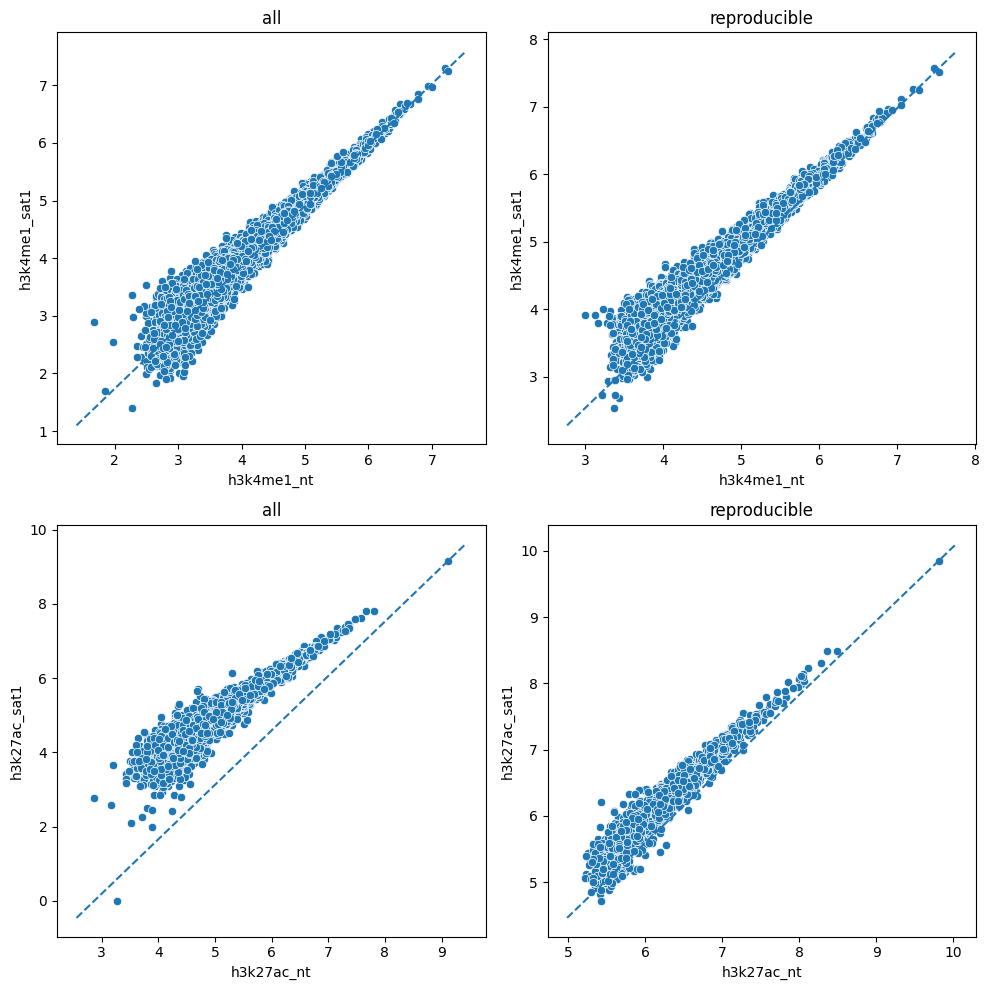

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt


datasets = ['h3k4me1', 'h3k27ac']
peaksets = ['all', 'reproducible']
fig, axs = plt.subplots(
    len(datasets), 
    len(peaksets)
)

for axs_row, dataset in zip(axs, datasets):
    for ax, k in zip(axs_row, peaksets):
        sns.scatterplot(
            data = averaged_counts[f'{dataset}_{k}'],
            x = 'nt',
            y = 'sat1',
            ax = ax
        )
        ax.set_title(k)
        ax.set_xlabel(f'{dataset}_nt')
        ax.set_ylabel(f'{dataset}_sat1')
        
        ax.plot(
            ax.get_xlim(),
            ax.get_ylim(),
            ls = '--'
        )

fig.set_figwidth(10)
fig.set_figheight(10)
fig.tight_layout()